___

### Image Classifier

CNN that classifies Fashion MNIST dataset using PyTorch with 92% accuracy. Implemented custom Conv2d module, orthogonal ititialization, and cross entropy loss.



In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import sys
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
# 0=xe, 1=othogonal, 2=uniform None=default
InitStrategy = 1


class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
      self.__dict__.update(locals())
      super(Conv2d, self).__init__()
      
      self.weight = Parameter(torch.Tensor(self.out_channels, 
                                 self.in_channels, 
                                 *kernel_size))
      self.bias = Parameter(torch.Tensor(out_channels))
      
      initOptions={
          0: self.xeInit,
          1: self.orthogonalInit,
          2: self.uniformInit,           
      }

      initMethod = initOptions.get(InitStrategy, self.defaultInit)
      initMethod()
      
      
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)
  
  def defaultInit(self):
    self.uniformInit()
  
  def xeInit(self, gain=1):
    self.weight.data = nn.init.xavier_uniform(self.weight.data)
    
  def orthogonalInit(self):
    X = np.random.random((self.out_channels, self.in_channels, *self.kernel_size))
    U, _, Vt = np.linalg.svd(X, full_matrices=False)
    if x.shape[0] > x.shape[1]:
      weight = U
    else:
      weight = Vt
    W = weight.reshape(self.out_channels, self.in_channels, *self.kernel_size)
    self.weight = Parameter(torch.tensor(W).float())
    self.bias.data.uniform_(0, 0)
  
  def uniformInit(self):
    self.weight.data.uniform_(-1, 1)
    self.bias.data.uniform_(0, 0)
  
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100,
               reduce=None, reduction='mean'):
      super(CrossEntropyLoss, self).__init__()

  def forward(self, input, target):
      wrong_class_penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1) + sys.float_info.epsilon)
      n, classes = y_hat.size()
      b = torch.zeros((n, classes))
      b[np.arange(n), y_truth] = 1
      true_class_pred = torch.sum(y_hat * b.cuda(), dim=1)
      ce = torch.mean(-true_class_pred + wrong_class_penalty)

      return ce

class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10
    
    self.net = nn.Sequential(
          nn.Conv2d(c, 125, (3,3), padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(125, 125, (3,3), padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(125, 125, (3,3), padding=(1,1)),
          nn.Conv2d(125, output, (28,28), padding=(0,0))
    )
    
  def forward(self, x):
    net_result = self.net(x)
    squeezed = net_result.squeeze(2).squeeze(2)
    return squeezed
    
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,
                                      train=train, 
                                      transform=transforms.ToTensor(),
                                      download=True)
    self.e = torch.eye(10)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return 42 #len(self.data)
  
  
training_set = FashionMNISTProcessedDataset('/tmp/fasionmnist', train=True)
validation_set = FashionMNISTProcessedDataset('/tmp/fasionmnist', train=False)

model = ConvNetwork(training_set)

model = model.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

training_data_loader = DataLoader(training_set,
                         batch_size=42,
                         pin_memory=True)
val_loader = DataLoader(validation_set,
                         batch_size=42,
                         pin_memory=True)

losses = []
validations = []
plt_train_accuracy = []
plt_valid_accuracy = []
plt_train_loss = []
plt_valid_loss = []

for epoch in range(100):
  loop = tqdm(total=len(training_data_loader), position=0)
  
  for batch, (x, y_truth) in enumerate(training_data_loader):
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss)
    plt_train_accuracy.append((y_hat.argmax(1) == y_truth).float().mean())
    plt_train_loss.append(loss.item())
    
  if batch % 15 == 0:
    val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                  for x, y, in val_loader])
    validations.append((len(losses), val))
    plt_valid_accuracy.append((y_hat.argmax(1) == y_truth).float().mean())
    plt_valid_loss.append(val.item())
    
  a, b = zip(*validations)
  loop.set_description('loss:{:.4f} --- validation loss:{:.2f}'.format(plt_train_loss[-1], plt_valid_loss[-1]))
  loop.update(1)
  loop.close()
  

loss:0.4555 --- validation loss:0.46: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]


tensor(0.9286, device='cuda:0')
tensor(0.9286, device='cuda:0')


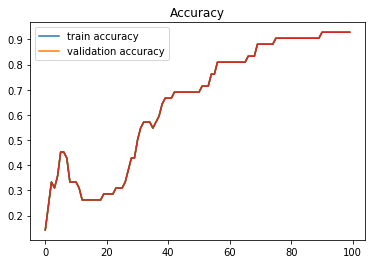

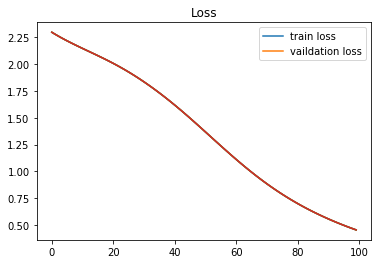

In [0]:
print(plt_train_accuracy[-1])
print(plt_valid_accuracy[-1])

plt.title("Accuracy")
plt.plot(plt_train_accuracy, label='train accuracy')
plt.plot(plt_valid_accuracy, label='validation accuracy')
plt.plot(range(len(plt_train_accuracy)), plt_train_accuracy)
plt.plot(range(len(plt_valid_accuracy)), plt_valid_accuracy)
plt.legend()
plt.show()

plt.title("Loss")
plt.plot(plt_train_loss, label='train loss')
plt.plot(plt_valid_loss, label='vaildation loss')
plt.plot(range(len(plt_train_loss)), plt_train_loss)
plt.plot(range(len(plt_valid_loss)), plt_valid_loss)
plt.legend()
plt.show()

In [0]:
# prints number of parameters
numParameters = 0
for p in model.parameters():
  numParameters = numParameters + np.prod(p.size())
print(numParameters)

1262760


In [0]:
# Kernel size test
# (c=3, h=10, w=10) => (c=10, h=8, w=8) : out=10, kernel_size=(3,3), padding=(0,0)

c = nn.Conv2d(3, 65, kernel_size=(3,3), padding=(2,2))
c(torch.zeros(1, 3, 10, 10)).size()

torch.Size([1, 65, 12, 12])

In [0]:
# RAM problem debugging
!nvidia-smi

Tue Sep 17 17:35:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    34W /  70W |    803MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  